USE LATENT VALUE INSTEAD OF KLD FOR GAUSSIAN CVAE

LOAD DATA

In [1]:
import numpy as np
from math import ceil
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, functional

/users/PES0841/yizicheng/.conda/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class THICKNESS(Dataset):
    def __init__(self, input_nm = 'x', output_nm = 'y', mode = 'train', transform=None):
        if mode == 'train':
            root_input = input_nm + '_train.npy'
            root_output = output_nm + '_train.npy'
        elif mode == 'val':
            root_input = input_nm + '_val.npy'
            root_output = output_nm + '_val.npy'
        else:
            root_input = input_nm + '_test.npy'
            root_output = output_nm + '_test.npy'
            
        self.original_input = np.load(root_input)
        self.original_output = np.load(root_output)
        self.transform = transform
        
    def __len__(self):
        return len(self.original_input)
    
    def __getitem__(self, item):
        inp = self.original_input[item]
        out = self.original_output[item]
        sample = {"input": inp, "output": out}
        if self.transform:
            sample = self.transform(sample)

        return sample
    
class ToTensor:
    def __call__(self, sample):
        sample["input"] = torch.as_tensor(sample["input"], dtype=torch.float32)
        sample["output"] = torch.as_tensor(sample["output"], dtype=torch.float32)
        
        return sample
    
def get_data(batch_size):
    transforms = ToTensor()
    
    datasets, dataloaders, dataset_sizes = {}, {}, {}
    for mode in ["train", "val", "test"]:
        datasets[mode] = THICKNESS(mode = mode, transform = transforms)
        dataloaders[mode] = DataLoader(
            datasets[mode],
            batch_size=batch_size,
#             shuffle= True,
            shuffle= mode == "train",
            num_workers=0,
        )
        dataset_sizes[mode] = len(datasets[mode])

    return datasets, dataloaders, dataset_sizes

In [3]:
datasets, dataloaders, dataset_sizes = get_data(batch_size=64)

In [4]:
dataloader = DataLoader(datasets['test'], batch_size=dataset_sizes['test'], shuffle=False)

batch = next(iter(dataloader))

inputs = batch["input"]
outputs = batch["output"]

LOAD BASELINE NET

In [5]:
import copy
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm


class BaselineNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(30, 30))
        self.maxpool = nn.MaxPool2d(kernel_size=(5, 5), stride=(5, 5))
        self.fc1 = nn.Linear(7840, 100)
        self.fc2 = nn.Linear(100, 4)
        
        self.relu = nn.ReLU()
        self.softplus = nn.Softplus()
        self.leakyrelu = nn.LeakyReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = x.view(-1, 171, 171)
        x = x.unsqueeze(1)
        hidden = self.leakyrelu(self.conv(x))
        hidden = self.maxpool(hidden)
        
        hidden = torch.flatten(hidden, 1)
        hidden = self.leakyrelu(self.fc1(hidden))
        
        y = self.fc2(hidden)
        return y

In [6]:
baseline_net = BaselineNet()
baseline_net.load_state_dict(torch.load('baseline_net.pth'))

<All keys matched successfully>

LOAD CVAE NET 1:GAU_CVAE

In [7]:
# Copyright Contributors to the Pyro project.
# SPDX-License-Identifier: Apache-2.0
# import os

# os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, TraceMeanField_ELBO


class Encoder(nn.Module):
    def __init__(self, z_dim, out_channel_1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=5, out_channels=out_channel_1, kernel_size=(30, 30))
        self.maxpool = nn.MaxPool2d(kernel_size=(5, 5), stride=(5, 5))
        
        #in_features should be y.shape[1]
        self.fc1 = nn.Linear(in_features=7840, out_features=100)
        self.fc21 = nn.Linear(in_features=100, out_features=z_dim)
        self.fc22 = nn.Linear(in_features=100, out_features=z_dim)
        
        self.relu = nn.ReLU()
        self.softplus = nn.Softplus()
        self.leakyrelu = nn.LeakyReLU()
        self.tanh = nn.Tanh()

    def forward(self, x, y):
        # put x and y together in the same image for simplification
        x = x.view(-1, 171, 171)
        y = y.view(-1, 4)
        y = y.unsqueeze(2)
        #y.shape: (30,4,1)
        y_0 = y[:,0,:].repeat(1,171).unsqueeze(2).repeat(1,1,171)
        y_1 = y[:,1,:].repeat(1,171).unsqueeze(2).repeat(1,1,171)
        y_2 = y[:,2,:].repeat(1,171).unsqueeze(2).repeat(1,1,171)
        y_3 = y[:,3,:].repeat(1,171).unsqueeze(2).repeat(1,1,171)
        yc = torch.stack((y_0, y_1, y_2, y_3), dim = 1)
        xc = torch.cat((x.unsqueeze(1), yc),dim = 1)
        
        # then compute the hidden units
        hidden = self.leakyrelu(self.conv(xc))
        hidden = self.maxpool(hidden)
        
        hidden = torch.flatten(hidden, 1)
        
        hidden = self.leakyrelu(self.fc1(hidden))
    
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        z_loc = self.fc21(hidden)
        z_scale = torch.exp(self.fc22(hidden))
        return z_loc, z_scale


class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_1):
        super().__init__()
        self.fc1 = nn.Linear(z_dim, hidden_1)
        self.fc2 = nn.Linear(hidden_1, 4)
        
        self.relu = nn.ReLU()
        self.softplus = nn.Softplus()
        self.leakyrelu = nn.LeakyReLU()
        self.tanh = nn.Tanh()

    def forward(self, z):
        y = self.leakyrelu(self.fc1(z))
        y = self.fc2(y)
        return y


class CVAE(nn.Module):
    def __init__(self, z_dim, hidden_1, pre_trained_baseline_net):
        super().__init__()
        # The CVAE is composed of multiple MLPs, such as recognition network
        # qφ(z|x, y), (conditional) prior network pθ(z|x), and generation
        # network pθ(y|x, z). Also, CVAE is built on top of the NN: not only
        # the direct input x, but also the initial guess y_hat made by the NN
        # are fed into the prior network.
        self.baseline_net = pre_trained_baseline_net
        self.prior_net = Encoder(z_dim, 10)
        self.generation_net = Decoder(z_dim, hidden_1)
        self.recognition_net = Encoder(z_dim, 10)

    def model(self, xs, ys=None):
        # register this pytorch module and all of its sub-modules with pyro
        pyro.module("generation_net", self)
        batch_size = xs.shape[0]
        with pyro.plate("data"):

            # Prior network uses the baseline predictions as initial guess.
            # This is the generative process with recurrent connection
            with torch.no_grad():
                # this ensures the training process does not change the
                # baseline network
                y_hat = self.baseline_net(xs).view(-1,4)

            # sample the handwriting style from the prior distribution, which is
            # modulated by the input xs.
            prior_loc, prior_scale = self.prior_net(xs, y_hat)
            zs = pyro.sample("z", dist.Normal(prior_loc, prior_scale).to_event(1))

            # the output y is generated from the distribution pθ(y|x, z)
            y_out = self.generation_net(zs)

            if ys is not None:
                # In training, we will only sample in the masked image
                pyro.sample(
                    "y",
                    dist.Normal(y_out, 0.1, validate_args=False).to_event(1),
                    obs=ys,
                )
                
            else:
                # In testing, no need to sample: the output is already a
                # probability in [0, 1] range, which better represent pixel
                # values considering grayscale. If we sample, we will force
                # each pixel to be  either 0 or 1, killing the grayscale
                pyro.deterministic("y", y_out.detach())

            # return the y_out so we can visualize it later
            return y_out

    def guide(self, xs, ys=None):
        with pyro.plate("data"):
            if ys is None:
                # at inference time, ys is not provided. In that case,
                # the model uses the prior network
                y_hat = self.baseline_net(xs).view(-1,4)
                loc, scale = self.prior_net(xs, y_hat)
            else:
                # at training time, uses the variational distribution
                # q(z|x,y) = normal(loc(x,y),scale(x,y))
                loc, scale = self.recognition_net(xs, ys)

            pyro.sample("z", dist.Normal(loc, scale).to_event(1))


In [8]:
cvae_net = CVAE(10, 100, baseline_net)
cvae_net.load_state_dict(torch.load('Gaucvae_net.pth'))

<All keys matched successfully>

In [9]:
with torch.no_grad():
    pos_loc, pos_scale = cvae_net.recognition_net(inputs, outputs)
    pos_z = dist.Normal(pos_loc, pos_scale).to_event(1).sample()
    
    y_hat = cvae_net.baseline_net(inputs).view(-1,4)
    prior_loc, prior_scale = cvae_net.prior_net(inputs, y_hat)
    prior_z = dist.Normal(prior_loc, prior_scale).to_event(1).sample()

In [10]:
pos_loc = pos_loc.cpu().detach()
pos_scale = pos_scale.cpu().detach()
pos_z = pos_z.cpu().detach()

prior_loc = prior_loc.cpu().detach()
prior_scale = prior_scale.cpu().detach()
prior_z = prior_z.cpu().detach()

In [11]:
beta = cvae_net.generation_net.fc1.weight.detach().T

In [12]:
latent_dic = {'GaussianCVAE':[prior_loc,prior_scale,prior_z,pos_loc,pos_scale,pos_z,beta]}

LOAD CVAE NET 2:SB_CVAE

In [13]:
# Copyright Contributors to the Pyro project.
# SPDX-License-Identifier: Apache-2.0
# import os

# os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, TraceMeanField_ELBO


class Encoder(nn.Module):
    def __init__(self, z_dim, out_channel_1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=5, out_channels=out_channel_1, kernel_size=(30, 30))
        self.maxpool = nn.MaxPool2d(kernel_size=(5, 5), stride=(5, 5))
        
        #in_features should be y.shape[1]
        self.fc1 = nn.Linear(in_features=7840, out_features=100)
        self.fcalpha = nn.Linear(in_features=100, out_features=z_dim-1)
        self.fcbeta = nn.Linear(in_features=100, out_features=z_dim-1)
        
        self.relu = nn.ReLU()
        self.softplus = nn.Softplus()
        self.leakyrelu = nn.LeakyReLU()
        self.tanh = nn.Tanh()

    def forward(self, x, y):
        # put x and y together in the same image for simplification
        x = x.view(-1, 171, 171)
        y = y.view(-1, 4)
        y = y.unsqueeze(2)
        #y.shape: (30,4,1)
        y_0 = y[:,0,:].repeat(1,171).unsqueeze(2).repeat(1,1,171)
        y_1 = y[:,1,:].repeat(1,171).unsqueeze(2).repeat(1,1,171)
        y_2 = y[:,2,:].repeat(1,171).unsqueeze(2).repeat(1,1,171)
        y_3 = y[:,3,:].repeat(1,171).unsqueeze(2).repeat(1,1,171)
        yc = torch.stack((y_0, y_1, y_2, y_3), dim = 1)
        xc = torch.cat((x.unsqueeze(1), yc),dim = 1)
        
        # then compute the hidden units
        hidden = self.leakyrelu(self.conv(xc))
        hidden = self.maxpool(hidden)
        
        hidden = torch.flatten(hidden, 1)
        
        hidden = self.leakyrelu(self.fc1(hidden))
    
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        alpha = self.softplus(self.fcalpha(hidden))
        beta = self.softplus(self.fcbeta(hidden))
        
#         alpha = torch.maximum(torch.tensor((0.00001)), torch.log(1+torch.exp(alpha)))
#         beta = torch.maximum(torch.tensor((0.00001)), torch.log(1+torch.exp(beta)))
        return alpha, beta


class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_1):
        super().__init__()
        self.fc1 = nn.Linear(z_dim, hidden_1)
        self.fc2 = nn.Linear(hidden_1, 4)
        
        self.relu = nn.ReLU()
        self.softplus = nn.Softplus()
        self.leakyrelu = nn.LeakyReLU()
        self.tanh = nn.Tanh()

    def forward(self, z):
        y = self.leakyrelu(self.fc1(z))
        y = self.fc2(y)
        return y
    

def SB_weights(v):
    v_cumprod = (1 - v).cumprod(-1)
    return F.pad(v, (0, 1), value=1) * F.pad(v_cumprod, (1, 0), value=1)

class CVAE(nn.Module):
    def __init__(self, z_dim, hidden_1, pre_trained_baseline_net):
        super().__init__()
        # The CVAE is composed of multiple MLPs, such as recognition network
        # qφ(z|x, y), (conditional) prior network pθ(z|x), and generation
        # network pθ(y|x, z). Also, CVAE is built on top of the NN: not only
        # the direct input x, but also the initial guess y_hat made by the NN
        # are fed into the prior network.
        self.baseline_net = pre_trained_baseline_net
        self.prior_net = Encoder(z_dim, 10)
        self.generation_net = Decoder(z_dim, hidden_1)
        self.recognition_net = Encoder(z_dim, 10)

    def model(self, xs, ys=None):
        # register this pytorch module and all of its sub-modules with pyro
        pyro.module("generation_net", self)
        batch_size = xs.shape[0]
        with pyro.plate("data"):

            # Prior network uses the baseline predictions as initial guess.
            # This is the generative process with recurrent connection
            with torch.no_grad():
                # this ensures the training process does not change the
                # baseline network
                y_hat = self.baseline_net(xs).view(-1,4)

            # sample the handwriting style from the prior distribution, which is
            # modulated by the input xs.
            prior_alpha, prior_beta = self.prior_net(xs, y_hat)
            zs = pyro.sample("z", dist.Beta(prior_alpha, prior_beta).to_event(1))
            latent_pi = SB_weights(zs)

            # the output y is generated from the distribution pθ(y|x, z)
            y_out = self.generation_net(latent_pi)

            if ys is not None:
                # In training, we will only sample in the masked image
                pyro.sample(
                    "y",
                    dist.Normal(y_out, 0.1, validate_args=False).to_event(1),
                    obs=ys,
                )
                
            else:
                # In testing, no need to sample: the output is already a
                # probability in [0, 1] range, which better represent pixel
                # values considering grayscale. If we sample, we will force
                # each pixel to be  either 0 or 1, killing the grayscale
                pyro.deterministic("y", y_out.detach())

            # return the y_out so we can visualize it later
            return y_out

    def guide(self, xs, ys=None):
        with pyro.plate("data"):
            if ys is None:
                # at inference time, ys is not provided. In that case,
                # the model uses the prior network
                y_hat = self.baseline_net(xs).view(-1,4)
                alpha, beta = self.prior_net(xs, y_hat)
            else:
                # at training time, uses the variational distribution
                # q(z|x,y) = normal(loc(x,y),scale(x,y))
                alpha, beta = self.recognition_net(xs, ys)

            pyro.sample("z", dist.Beta(alpha, beta).to_event(1))

In [14]:
cvae_net = CVAE(10, 100, baseline_net)
cvae_net.load_state_dict(torch.load('SBcvae_net.pth'))

<All keys matched successfully>

In [15]:
with torch.no_grad():
    y_hat = cvae_net.baseline_net(inputs).view(-1,4)
    prior_alpha, prior_beta = cvae_net.prior_net(inputs, y_hat)
    prior_z = dist.Beta(prior_alpha, prior_beta).to_event(1).sample()
    prior_latent_pi = SB_weights(prior_z)
    
    pos_alpha, pos_beta = cvae_net.recognition_net(inputs, outputs)
    pos_z = dist.Beta(pos_alpha, pos_beta).to_event(1).sample()
    pos_latent_pi = SB_weights(pos_z)

In [16]:
pos_alpha = pos_alpha.cpu().detach()
pos_beta = pos_beta.cpu().detach()
pos_latent_pi = pos_latent_pi.cpu().detach()

prior_alpha = prior_alpha.cpu().detach()
prior_beta = prior_beta.cpu().detach()
prior_latent_pi = prior_latent_pi.cpu().detach()

In [17]:
beta = cvae_net.generation_net.fc1.weight.detach().T

In [18]:
latent_dic['SBCVAE'] = [prior_alpha,prior_beta,prior_latent_pi,pos_alpha,pos_beta,pos_latent_pi,beta]

LOAD CVAE NET 3:SoftmaxGau_DirCVAE

In [19]:
# Copyright Contributors to the Pyro project.
# SPDX-License-Identifier: Apache-2.0
# import os

# os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, TraceMeanField_ELBO


class Encoder(nn.Module):
    def __init__(self, z_dim, out_channel_1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=5, out_channels=out_channel_1, kernel_size=(30, 30))
        self.maxpool = nn.MaxPool2d(kernel_size=(5, 5), stride=(5, 5))
        
        #in_features should be y.shape[1]
        self.fc1 = nn.Linear(in_features=7840, out_features=100)
        self.fcmu = nn.Linear(in_features=100, out_features=z_dim)
        self.fclv = nn.Linear(in_features=100, out_features=z_dim)
#         self.bnmu = nn.BatchNorm1d(z_dim, affine=False)
#         self.bnlv = nn.BatchNorm1d(z_dim, affine=False)
        
        self.relu = nn.ReLU()
        self.softplus = nn.Softplus()
        self.leakyrelu = nn.LeakyReLU()
        self.tanh = nn.Tanh()

    def forward(self, x, y):
        # put x and y together in the same image for simplification
        x = x.view(-1, 171, 171)
        y = y.view(-1, 4)
        y = y.unsqueeze(2)
        #y.shape: (30,4,1)
        y_0 = y[:,0,:].repeat(1,171).unsqueeze(2).repeat(1,1,171)
        y_1 = y[:,1,:].repeat(1,171).unsqueeze(2).repeat(1,1,171)
        y_2 = y[:,2,:].repeat(1,171).unsqueeze(2).repeat(1,1,171)
        y_3 = y[:,3,:].repeat(1,171).unsqueeze(2).repeat(1,1,171)
        yc = torch.stack((y_0, y_1, y_2, y_3), dim = 1)
        xc = torch.cat((x.unsqueeze(1), yc),dim = 1)
        
        # then compute the hidden units
        hidden = self.leakyrelu(self.conv(xc))
        hidden = self.maxpool(hidden)
        
        hidden = torch.flatten(hidden, 1)
        
        hidden = self.leakyrelu(self.fc1(hidden))
    
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
#         z_logtheta_loc = self.bnmu(self.fcmu(hidden))
#         logtheta_logvar = self.bnlv(self.fclv(hidden))
        z_logtheta_loc = self.fcmu(hidden)
        logtheta_logvar = self.fclv(hidden)
        z_logtheta_scale = (0.5 * logtheta_logvar).exp()
        return z_logtheta_loc, z_logtheta_scale


class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_1):
        super().__init__()
        self.fc1 = nn.Linear(z_dim, hidden_1)
        self.fc2 = nn.Linear(hidden_1, 4)
        
        self.relu = nn.ReLU()
        self.softplus = nn.Softplus()
        self.leakyrelu = nn.LeakyReLU()
        self.tanh = nn.Tanh()

    def forward(self, z):
        y = self.leakyrelu(self.fc1(z))
        y = self.fc2(y)
        return y


class CVAE(nn.Module):
    def __init__(self, z_dim, hidden_1, pre_trained_baseline_net):
        super().__init__()
        # The CVAE is composed of multiple MLPs, such as recognition network
        # qφ(z|x, y), (conditional) prior network pθ(z|x), and generation
        # network pθ(y|x, z). Also, CVAE is built on top of the NN: not only
        # the direct input x, but also the initial guess y_hat made by the NN
        # are fed into the prior network.
        self.baseline_net = pre_trained_baseline_net
        self.prior_net = Encoder(z_dim, 10)
        self.generation_net = Decoder(z_dim, hidden_1)
        self.recognition_net = Encoder(z_dim, 10)

    def model(self, xs, ys=None):
        # register this pytorch module and all of its sub-modules with pyro
        pyro.module("generation_net", self)
        batch_size = xs.shape[0]
        with pyro.plate("data"):

            # Prior network uses the baseline predictions as initial guess.
            # This is the generative process with recurrent connection
            with torch.no_grad():
                # this ensures the training process does not change the
                # baseline network
                y_hat = self.baseline_net(xs).view(-1,4)

            # sample the handwriting style from the prior distribution, which is
            # modulated by the input xs.
            prior_loc, prior_scale = self.prior_net(xs, y_hat)
            zs = pyro.sample("z", dist.Normal(prior_loc, prior_scale).to_event(1))
            zs = F.softmax(zs,-1)

            # the output y is generated from the distribution pθ(y|x, z)
            y_out = self.generation_net(zs)

            if ys is not None:
                # In training, we will only sample in the masked image
                pyro.sample(
                    "y",
                    dist.Normal(y_out, 0.1, validate_args=False).to_event(1),
                    obs=ys,
                )
                
            else:
                # In testing, no need to sample: the output is already a
                # probability in [0, 1] range, which better represent pixel
                # values considering grayscale. If we sample, we will force
                # each pixel to be  either 0 or 1, killing the grayscale
                pyro.deterministic("y", y_out.detach())

            # return the y_out so we can visualize it later
            return y_out

    def guide(self, xs, ys=None):
        with pyro.plate("data"):
            if ys is None:
                # at inference time, ys is not provided. In that case,
                # the model uses the prior network
                y_hat = self.baseline_net(xs).view(-1,4)
                loc, scale = self.prior_net(xs, y_hat)
            else:
                # at training time, uses the variational distribution
                # q(z|x,y) = normal(loc(x,y),scale(x,y))
                loc, scale = self.recognition_net(xs, ys)

            pyro.sample("z", dist.Normal(loc, scale).to_event(1))

In [20]:
cvae_net = CVAE(10, 100, baseline_net)
cvae_net.load_state_dict(torch.load('softmaxGau_Dircvae_net.pth'))

<All keys matched successfully>

In [21]:
with torch.no_grad():
    pos_loc, pos_scale = cvae_net.recognition_net(inputs, outputs)
    pos_z = dist.Normal(pos_loc, pos_scale).to_event(1).sample()
    pos_z = F.softmax(pos_z,-1)
    
    y_hat = cvae_net.baseline_net(inputs).view(-1,4)
    prior_loc, prior_scale = cvae_net.prior_net(inputs, y_hat)
    prior_z = dist.Normal(prior_loc, prior_scale).to_event(1).sample()
    prior_z = F.softmax(prior_z,-1)

In [22]:
pos_loc = pos_loc.cpu().detach()
pos_scale = pos_scale.cpu().detach()
pos_z = pos_z.cpu().detach()

prior_loc = prior_loc.cpu().detach()
prior_scale = prior_scale.cpu().detach()
prior_z = prior_z.cpu().detach()

In [23]:
beta = cvae_net.generation_net.fc1.weight.detach().T

In [24]:
latent_dic['SoftmaxGau_DirCVAE'] = [prior_loc,prior_scale,prior_z,pos_loc,pos_scale,pos_z,beta]

LOAD CVAE NET 4:Gamma_Dircvae

In [25]:
# Copyright Contributors to the Pyro project.
# SPDX-License-Identifier: Apache-2.0
# import os

# os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, TraceMeanField_ELBO


class Encoder(nn.Module):
    def __init__(self, z_dim, out_channel_1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=5, out_channels=out_channel_1, kernel_size=(30, 30))
        self.maxpool = nn.MaxPool2d(kernel_size=(5, 5), stride=(5, 5))
        
        #in_features should be y.shape[1]
        self.fc1 = nn.Linear(in_features=7840, out_features=100)
        self.fcalpha = nn.Linear(in_features=100, out_features=z_dim)
        
        self.relu = nn.ReLU()
        self.softplus = nn.Softplus()
        self.leakyrelu = nn.LeakyReLU()
        self.tanh = nn.Tanh()

    def forward(self, x, y):
        # put x and y together in the same image for simplification
        x = x.view(-1, 171, 171)
        y = y.view(-1, 4)
        y = y.unsqueeze(2)
        #y.shape: (30,4,1)
        y_0 = y[:,0,:].repeat(1,171).unsqueeze(2).repeat(1,1,171)
        y_1 = y[:,1,:].repeat(1,171).unsqueeze(2).repeat(1,1,171)
        y_2 = y[:,2,:].repeat(1,171).unsqueeze(2).repeat(1,1,171)
        y_3 = y[:,3,:].repeat(1,171).unsqueeze(2).repeat(1,1,171)
        yc = torch.stack((y_0, y_1, y_2, y_3), dim = 1)
        xc = torch.cat((x.unsqueeze(1), yc),dim = 1)
        
        # then compute the hidden units
        hidden = self.leakyrelu(self.conv(xc))
        hidden = self.maxpool(hidden)
        
        hidden = torch.flatten(hidden, 1)
        
        hidden = self.leakyrelu(self.fc1(hidden))
    
        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        alpha = self.softplus(self.fcalpha(hidden))
        
#         alpha = torch.maximum(torch.tensor((0.00001)), torch.log(1+torch.exp(alpha)))
        return alpha


class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_1):
        super().__init__()
        self.fc1 = nn.Linear(z_dim, hidden_1)
        self.fc2 = nn.Linear(hidden_1, 4)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.leakyrelu = nn.LeakyReLU()

    def forward(self, z):
        y = self.leakyrelu(self.fc1(z))
        y = self.fc2(y)
        return y


class CVAE(nn.Module):
    def __init__(self, z_dim, hidden_1, pre_trained_baseline_net):
        super().__init__()
        # The CVAE is composed of multiple MLPs, such as recognition network
        # qφ(z|x, y), (conditional) prior network pθ(z|x), and generation
        # network pθ(y|x, z). Also, CVAE is built on top of the NN: not only
        # the direct input x, but also the initial guess y_hat made by the NN
        # are fed into the prior network.
        self.baseline_net = pre_trained_baseline_net
        self.prior_net = Encoder(z_dim, 10)
        self.generation_net = Decoder(z_dim, hidden_1)
        self.recognition_net = Encoder(z_dim, 10)

    def model(self, xs, ys=None):
        # register this pytorch module and all of its sub-modules with pyro
        pyro.module("generation_net", self)
        batch_size = xs.shape[0]
        with pyro.plate("data"):

            # Prior network uses the baseline predictions as initial guess.
            # This is the generative process with recurrent connection
            with torch.no_grad():
                # this ensures the training process does not change the
                # baseline network
                y_hat = self.baseline_net(xs).view(-1,4)

            # sample the handwriting style from the prior distribution, which is
            # modulated by the input xs.
            prior_alpha = self.prior_net(xs, y_hat)
            zs = pyro.sample("z", dist.Gamma(prior_alpha, 1).to_event(1))
            zs = torch.div(zs,torch.reshape(torch.sum(zs,1), (-1, 1)))

            # the output y is generated from the distribution pθ(y|x, z)
            y_out = self.generation_net(zs)

            if ys is not None:
                # In training, we will only sample in the masked image
                pyro.sample(
                    "y",
                    dist.Normal(y_out, 0.1, validate_args=False).to_event(1),
                    obs=ys,
                )
                
            else:
                # In testing, no need to sample: the output is already a
                # probability in [0, 1] range, which better represent pixel
                # values considering grayscale. If we sample, we will force
                # each pixel to be  either 0 or 1, killing the grayscale
                pyro.deterministic("y", y_out.detach())

            # return the y_out so we can visualize it later
            return y_out

    def guide(self, xs, ys=None):
        with pyro.plate("data"):
            if ys is None:
                # at inference time, ys is not provided. In that case,
                # the model uses the prior network
                y_hat = self.baseline_net(xs).view(-1,4)
                alpha = self.prior_net(xs, y_hat)
            else:
                # at training time, uses the variational distribution
                # q(z|x,y) = normal(loc(x,y),scale(x,y))
                alpha = self.recognition_net(xs, ys)

            pyro.sample("z", dist.Gamma(alpha, 1).to_event(1))

In [26]:
cvae_net = CVAE(10, 100, baseline_net)
cvae_net.load_state_dict(torch.load('gamma_Dircvae.pth'))

<All keys matched successfully>

In [27]:
with torch.no_grad():
    y_hat = cvae_net.baseline_net(inputs).view(-1,4)
    prior_alpha = cvae_net.prior_net(inputs, y_hat)
    prior_z = dist.Gamma(prior_alpha, 1).to_event(1).sample()
    prior_zs = torch.div(prior_z,torch.reshape(torch.sum(prior_z,1), (-1, 1)))
    
    pos_alpha = cvae_net.recognition_net(inputs, outputs)
    pos_z = dist.Gamma(pos_alpha, 1).to_event(1).sample()
    pos_zs = torch.div(pos_z,torch.reshape(torch.sum(pos_z,1), (-1, 1)))

In [28]:
pos_alpha = pos_alpha.cpu().detach()
pos_zs = pos_zs.cpu().detach()

prior_alpha = prior_alpha.cpu().detach()
prior_zs = prior_zs.cpu().detach()

In [29]:
beta = cvae_net.generation_net.fc1.weight.detach().T

In [30]:
latent_dic['Gamma_DirCVAE'] = [prior_alpha,prior_alpha.new_ones(prior_alpha.shape),prior_zs,pos_alpha,pos_alpha.new_ones(pos_alpha.shape),pos_zs,beta]

LOAD CVAE NET 5:InvCDF_Gamma_Dircvae

In [31]:
# Copyright Contributors to the Pyro project.
# SPDX-License-Identifier: Apache-2.0
# import os

# os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO

import math
from torch.distributions import constraints
from pyro.distributions.torch_distribution import TorchDistribution
from numbers import Number
from torch.distributions.exp_family import ExponentialFamily
from torch.distributions.utils import broadcast_all
from pyro.distributions.torch_distribution import TorchDistributionMixin


class InvCDF_Gamma(ExponentialFamily, TorchDistribution):
    
    arg_constraints = {
        'concentration': constraints.positive,
        'rate': constraints.positive
    }
    support = constraints.nonnegative
    has_rsample = True
    
    @property
    def mean(self):
        return self.concentration / self.rate

    @property
    def mode(self):
        return ((self.concentration - 1) / self.rate).clamp(min=0)

    @property
    def variance(self):
        return self.concentration / self.rate.pow(2)
    
    def __init__(self, concentration, rate, validate_args=None):
        self.concentration, self.rate = broadcast_all(concentration, rate)
        if isinstance(concentration, Number) and isinstance(rate, Number):
            batch_shape = torch.Size()
        else:
            batch_shape = self.concentration.size()
        super().__init__(batch_shape, validate_args=validate_args)
        
    def expand(self, batch_shape, _instance=None):
        new = self._get_checked_instance(InvCDF_Gamma, _instance)
        batch_shape = torch.Size(batch_shape)
        new.concentration = self.concentration.expand(batch_shape)
        new.rate = self.rate.expand(batch_shape)
        super(InvCDF_Gamma, new).__init__(
            batch_shape, validate_args=False
        )
        new._validate_args = self._validate_args
        return new
        
    def rsample(self, sample_shape=torch.Size(), eps=0.001):
        shape = self._extended_shape(sample_shape)
        U = torch.empty(shape, dtype=self.concentration.dtype, device=self.concentration.device).uniform_(eps, 1. - eps)
        value = (self.rate.reciprocal())*torch.pow(U*self.concentration*torch.exp(torch.lgamma(self.concentration)), self.concentration.reciprocal())
#         value = _standard_gamma(self.concentration.expand(shape)) / self.rate.expand(shape)
        value.detach().clamp_(min=torch.finfo(value.dtype).tiny)  # do not record in autograd graph
        
        return value
        
    def log_prob(self, value):
        value = torch.as_tensor(value, dtype=self.rate.dtype, device=self.rate.device)
        if self._validate_args:
            self._validate_sample(value)

        return (torch.xlogy(self.concentration, self.rate) +
                torch.xlogy(self.concentration - 1, value) -
                self.rate * value - torch.lgamma(self.concentration))
    
    def entropy(self):
        return (self.concentration - torch.log(self.rate) + torch.lgamma(self.concentration) +
                (1.0 - self.concentration) * torch.digamma(self.concentration))
    
    @property
    def _natural_params(self):
        return (self.concentration - 1, -self.rate)

    def _log_normalizer(self, x, y):
        return torch.lgamma(x + 1) + (x + 1) * torch.log(-y.reciprocal())
    
    def cdf(self, value):
        if self._validate_args:
            self._validate_sample(value)
        return torch.special.gammainc(self.concentration, self.rate * value)

class pyroInvCDF_Gamma(InvCDF_Gamma, TorchDistributionMixin):
    def conjugate_update(self, other):
        """
        EXPERIMENTAL.
        """
        assert isinstance(other, InvCDF_Gamma)
        concentration = self.concentration + other.concentration - 1
        rate = self.rate + other.rate
        updated = InvCDF_Gamma(concentration, rate)

        def _log_normalizer(d):
            c = d.concentration
            return d.rate.log() * c - c.lgamma()

        log_normalizer = (
            _log_normalizer(self) + _log_normalizer(other) - _log_normalizer(updated)
        )
        return updated, log_normalizer

In [32]:
# Copyright Contributors to the Pyro project.
# SPDX-License-Identifier: Apache-2.0
# import os

# os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO


class Encoder(nn.Module):
    def __init__(self, z_dim, out_channel_1):
        super().__init__()
        self.dropout = nn.Dropout(0.6)
        self.conv = nn.Conv2d(in_channels=5, out_channels=out_channel_1, kernel_size=(30, 30))
        self.maxpool = nn.MaxPool2d(kernel_size=(5, 5), stride=(5, 5))
        
        #in_features should be y.shape[1]
        self.fc1 = nn.Linear(in_features=7840, out_features=50)
        self.fcalpha = nn.Linear(in_features=50, out_features=z_dim)
        self.batch_norm = nn.BatchNorm1d(z_dim)
        
        self.relu = nn.ReLU()
        self.softplus = nn.Softplus()
        self.leakyrelu = nn.LeakyReLU()
        self.tanh = nn.Tanh()

    def forward(self, x, y):
        # put x and y together in the same image for simplification
        x = x.view(-1, 171, 171)
        y = y.view(-1, 4)
        y = y.unsqueeze(2)
        #y.shape: (30,4,1)
        y_0 = y[:,0,:].repeat(1,171).unsqueeze(2).repeat(1,1,171)
        y_1 = y[:,1,:].repeat(1,171).unsqueeze(2).repeat(1,1,171)
        y_2 = y[:,2,:].repeat(1,171).unsqueeze(2).repeat(1,1,171)
        y_3 = y[:,3,:].repeat(1,171).unsqueeze(2).repeat(1,1,171)
        yc = torch.stack((y_0, y_1, y_2, y_3), dim = 1)
        xc = torch.cat((x.unsqueeze(1), yc),dim = 1)
        
        # then compute the hidden units
        hidden = self.leakyrelu(self.conv(xc))
        hidden = self.maxpool(hidden)
        
        hidden = torch.flatten(hidden, 1)
        hidden = self.dropout(hidden)
        
        hidden = self.leakyrelu(self.fc1(hidden))

        # then return a mean vector and a (positive) square root covariance
        # each of size batch_size x z_dim
        alpha = self.batch_norm(self.fcalpha(hidden))
        alpha = torch.maximum(torch.tensor((0.00001)), torch.log(1+torch.exp(alpha)))
        
        return alpha


class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_1):
        super().__init__()
        self.fc1 = nn.Linear(z_dim, hidden_1)
        self.fc2 = nn.Linear(hidden_1, 4)
        
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.leakyrelu = nn.LeakyReLU()

    def forward(self, z):
        y = self.leakyrelu(self.fc1(z))
        y = self.fc2(y)
        return y


class CVAE(nn.Module):
    def __init__(self, z_dim, hidden_1, pre_trained_baseline_net):
        super().__init__()
        # The CVAE is composed of multiple MLPs, such as recognition network
        # qφ(z|x, y), (conditional) prior network pθ(z|x), and generation
        # network pθ(y|x, z). Also, CVAE is built on top of the NN: not only
        # the direct input x, but also the initial guess y_hat made by the NN
        # are fed into the prior network.
        self.baseline_net = pre_trained_baseline_net
        self.prior_net = Encoder(z_dim, 10)
        self.generation_net = Decoder(z_dim, hidden_1)
        self.recognition_net = Encoder(z_dim, 10)

    def model(self, xs, ys=None):
        # register this pytorch module and all of its sub-modules with pyro
        pyro.module("generation_net", self)
        batch_size = xs.shape[0]
        with pyro.plate("data"):

            # Prior network uses the baseline predictions as initial guess.
            # This is the generative process with recurrent connection
            with torch.no_grad():
                # this ensures the training process does not change the
                # baseline network
                y_hat = self.baseline_net(xs).view(-1,4)

            # sample the handwriting style from the prior distribution, which is
            # modulated by the input xs.
            prior_alpha = self.prior_net(xs, y_hat)
            zs = pyro.sample("z", dist.Gamma(prior_alpha, 1).to_event(1))
            zs = torch.div(zs,torch.reshape(torch.sum(zs,1), (-1, 1)))

            # the output y is generated from the distribution pθ(y|x, z)
            y_out = self.generation_net(zs)

            if ys is not None:
                # In training, we will only sample in the masked image
                pyro.sample(
                    "y",
                    dist.Normal(y_out, 0.1, validate_args=False).to_event(1),
                    obs=ys,
                )
                
            else:
                # In testing, no need to sample: the output is already a
                # probability in [0, 1] range, which better represent pixel
                # values considering grayscale. If we sample, we will force
                # each pixel to be  either 0 or 1, killing the grayscale
                pyro.deterministic("y", y_out.detach())

            # return the y_out so we can visualize it later
            return y_out

    def guide(self, xs, ys=None):
        with pyro.plate("data"):
            if ys is None:
                # at inference time, ys is not provided. In that case,
                # the model uses the prior network
                y_hat = self.baseline_net(xs).view(-1,4)
                alpha = self.prior_net(xs, y_hat)
            else:
                # at training time, uses the variational distribution
                # q(z|x,y) = normal(loc(x,y),scale(x,y))
                alpha = self.recognition_net(xs, ys)

            pyro.sample("z", pyroInvCDF_Gamma(alpha, 1).to_event(1))

In [33]:
cvae_net = CVAE(10, 100, baseline_net)
cvae_net.load_state_dict(torch.load('InvCDF_gamma_Dircvae.pth'))

<All keys matched successfully>

In [34]:
with torch.no_grad():
    y_hat = cvae_net.baseline_net(inputs).view(-1,4)
    prior_alpha = cvae_net.prior_net(inputs, y_hat)
    prior_z = dist.Gamma(prior_alpha, 1).to_event(1).sample()
    prior_zs = torch.div(prior_z,torch.reshape(torch.sum(prior_z,1), (-1, 1)))
    
    pos_alpha = cvae_net.recognition_net(inputs, outputs)
    pos_z = pyroInvCDF_Gamma(pos_alpha, 1).to_event(1).sample()
    pos_zs = torch.div(pos_z,torch.reshape(torch.sum(pos_z,1), (-1, 1)))

In [35]:
pos_alpha = pos_alpha.cpu().detach()
pos_zs = pos_zs.cpu().detach()

prior_alpha = prior_alpha.cpu().detach()
prior_zs = prior_zs.cpu().detach()

In [36]:
beta = cvae_net.generation_net.fc1.weight.detach().T

In [37]:
latent_dic['InvCDF_Gamma_DirCVAE'] = [prior_alpha,prior_alpha.new_ones(prior_alpha.shape),prior_zs,pos_alpha,pos_alpha.new_ones(pos_alpha.shape),pos_zs,beta]

In [38]:
import pickle 

# with open('latent_dic_test.pkl', 'wb') as f:
#     pickle.dump(latent_dic, f)

with open('latent_dic_test.pkl', 'rb') as f:
    latent_dic = pickle.load(f)

PLOT: Sparsity in the latent representation vs sparsity in the decoder network

In [39]:
# import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

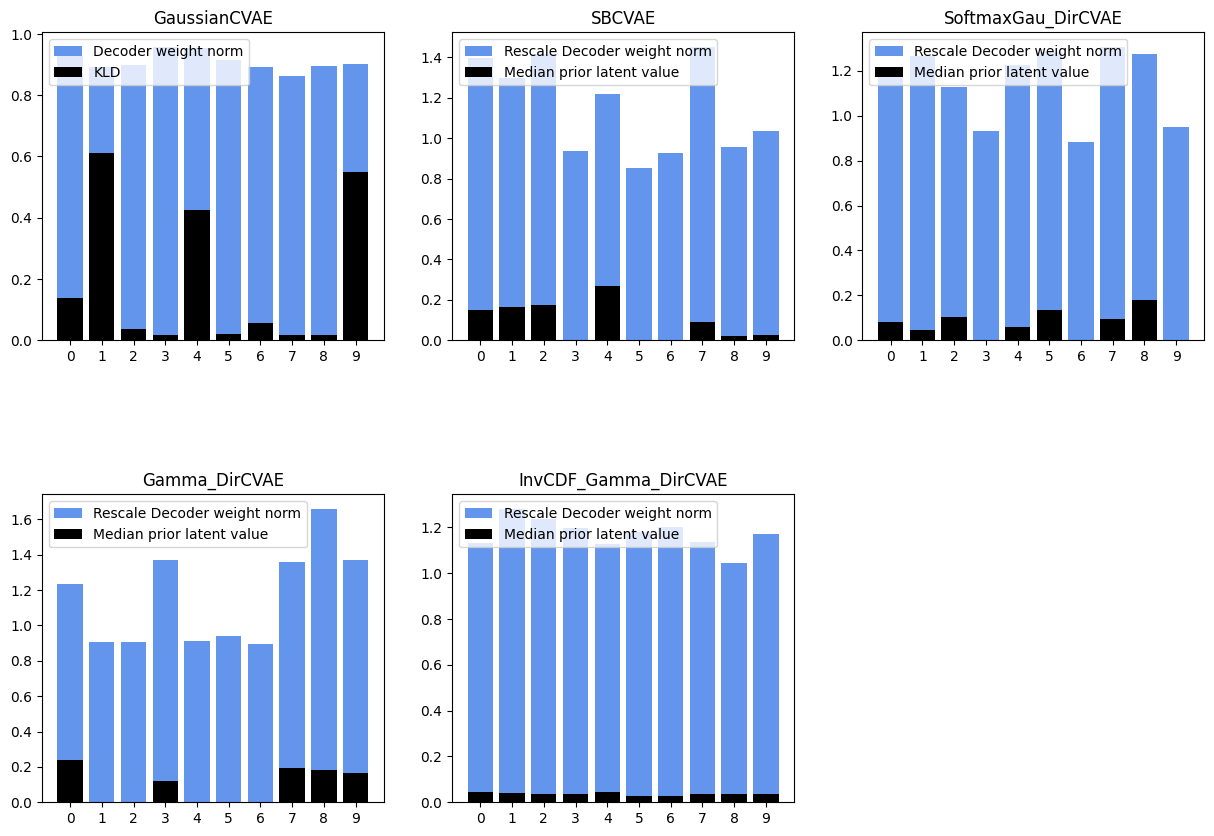

In [40]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
plt.subplots_adjust(hspace=0.5)

ax = axs.flatten()

z_dim = 10
scale_factor=[2,2,2,2,2]
GCVAE_legend = ["Decoder weight norm", "KLD"]

for i, (name, [prior_para1, prior_para2, prior_z, pos_para1, pos_para2, pos_z, weight]) in enumerate(latent_dic.items()):                                               
    L2_norm = torch.sqrt(torch.sum(torch.square(weight), 1))
    ax[i].bar(list(range(z_dim)), L2_norm/scale_factor[i], color='cornflowerblue')
    ax[i].set_xticks(list(range(z_dim)))
    if name == 'GaussianCVAE':
        p = dist.Normal(prior_para1, prior_para2)
        q = dist.Normal(pos_para1, pos_para2)
        KL_div = dist.kl.kl_divergence(p, q)
        
        ax[i].bar(list(range(z_dim)), torch.median(KL_div, 0)[0], color='black')
        ax[i].legend(GCVAE_legend, loc ="upper left")
    else:
        ax[i].bar(list(range(z_dim)), torch.median(prior_z, 0)[0], color='black')
        ax[i].legend(["Rescale Decoder weight norm", "Median prior latent value"], loc ="upper left")
        
    ax[i].set_title(name)

#skip last one
ax[5].axis('off')
fig.show()

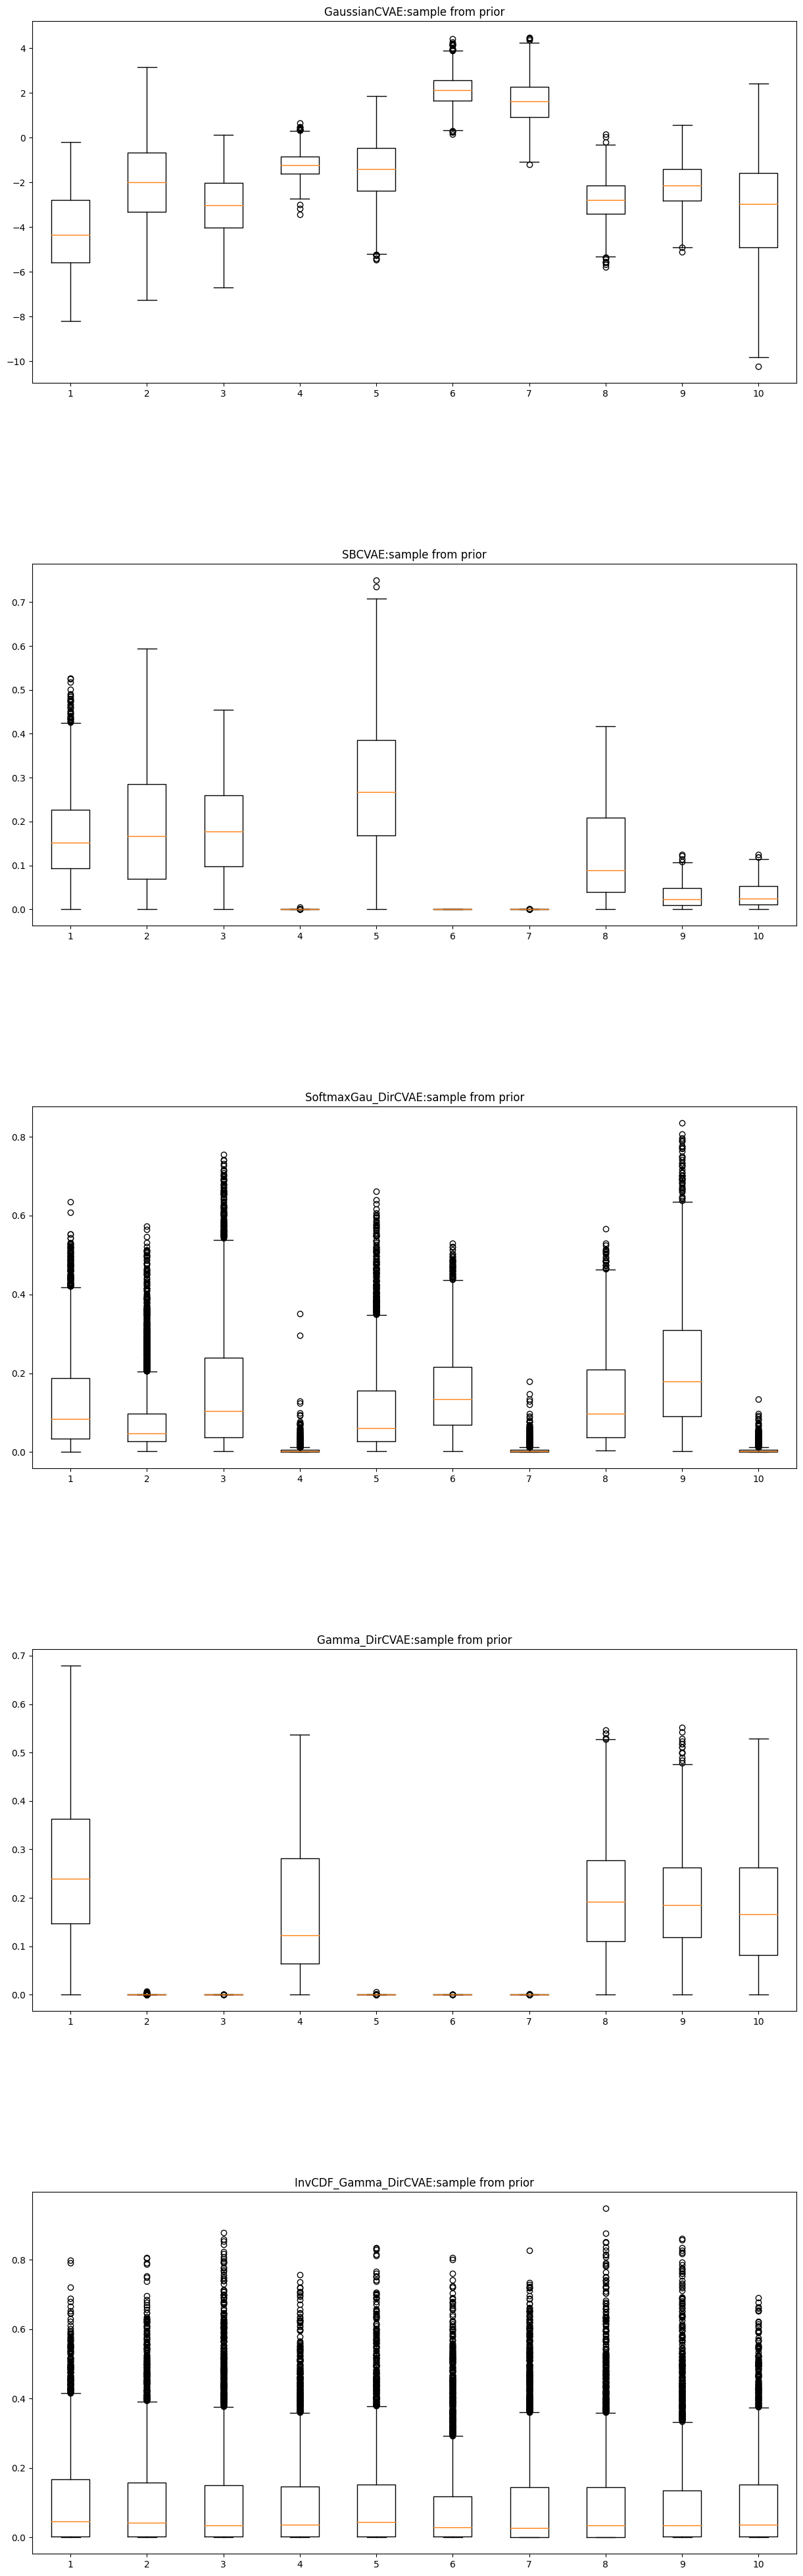

In [41]:
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(15, 50))
plt.subplots_adjust(hspace=0.5)

ax = axs.flatten()

z_dim = 10

for i, (name, [prior_para1, prior_para2, prior_z, pos_para1, pos_para2, pos_z, weight]) in enumerate(latent_dic.items()):                                               
    ax[i].boxplot(torch.transpose(prior_z, 0, 1), showfliers=True)
        
    ax[i].set_title(name+':sample from prior')

fig.show()

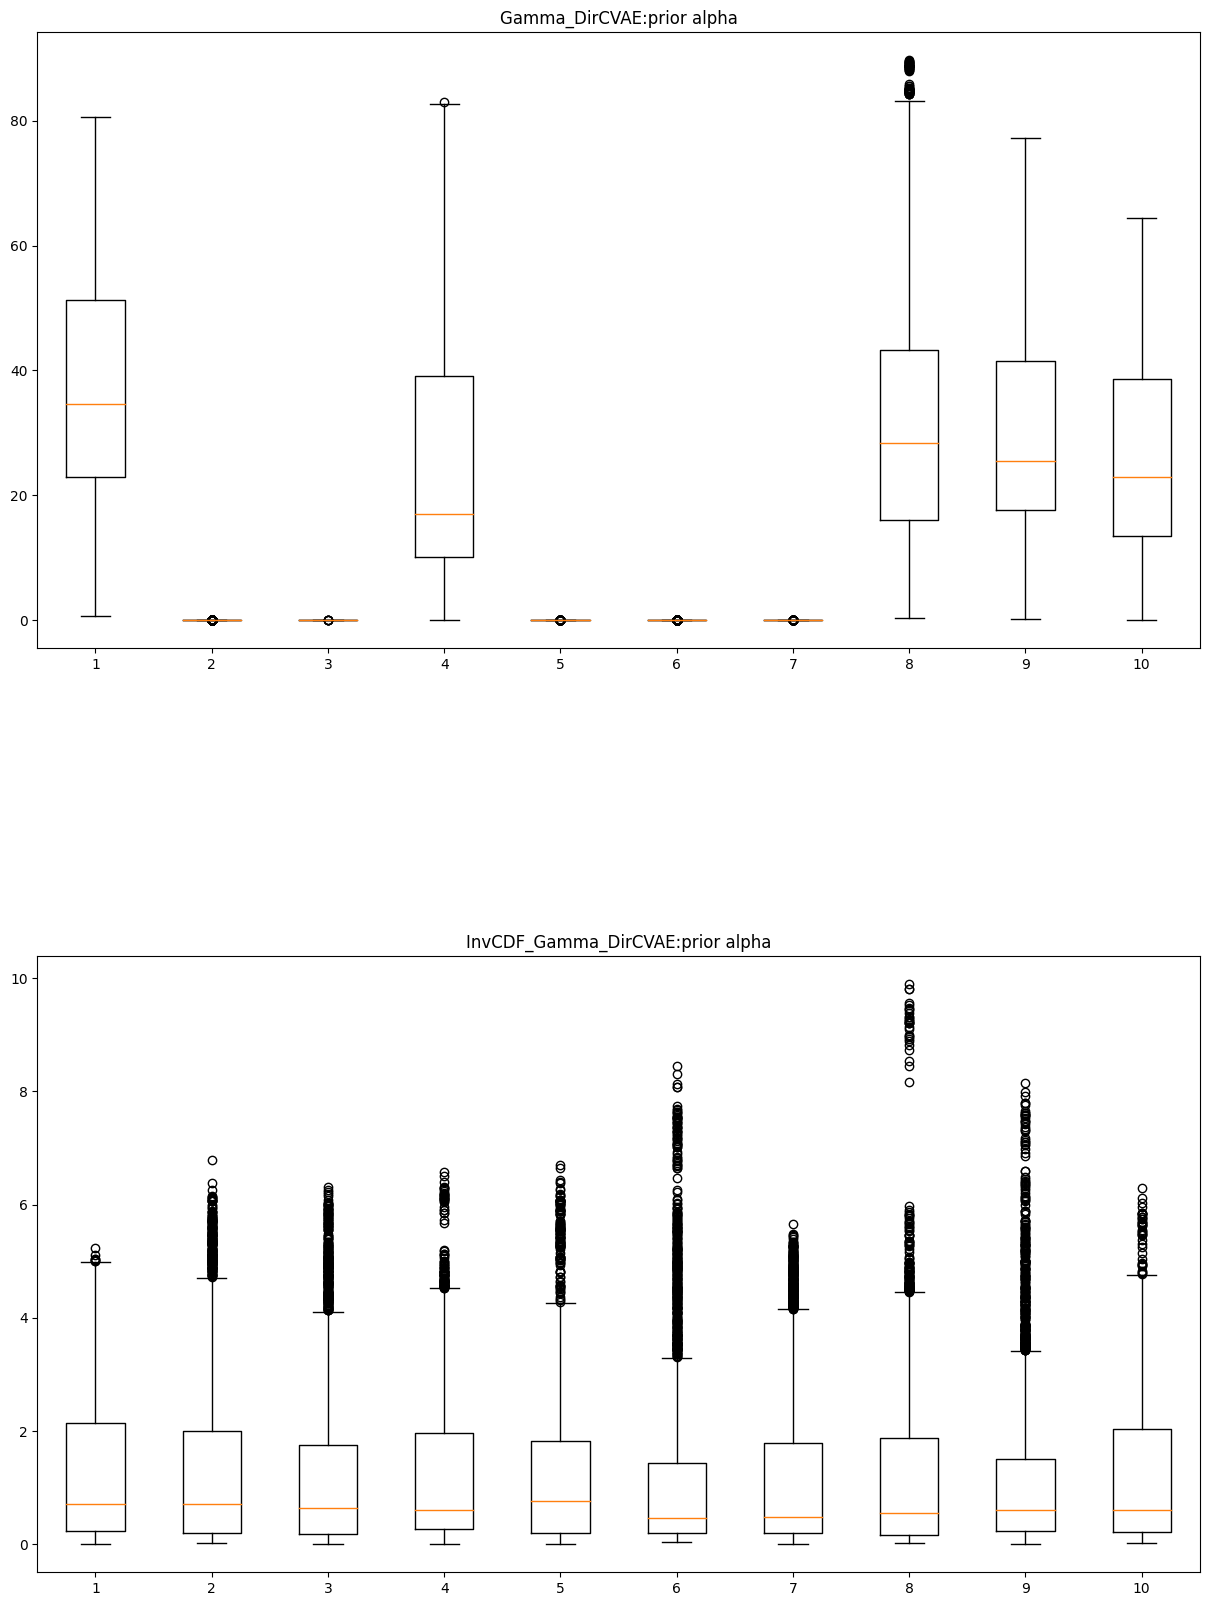

In [42]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(15, 20))
plt.subplots_adjust(hspace=0.5)

ax = axs.flatten()

z_dim = 10

for i, (name, [prior_para1, prior_para2, prior_z, pos_para1, pos_para2, pos_z, weight]) in enumerate(latent_dic.items()):                                               
    if i > 2:
        ax[i-3].boxplot(torch.transpose(prior_para1, 0, 1), showfliers=True)
        ax[i-3].set_title(name+':prior alpha')

fig.show()

t-SNE PLOT

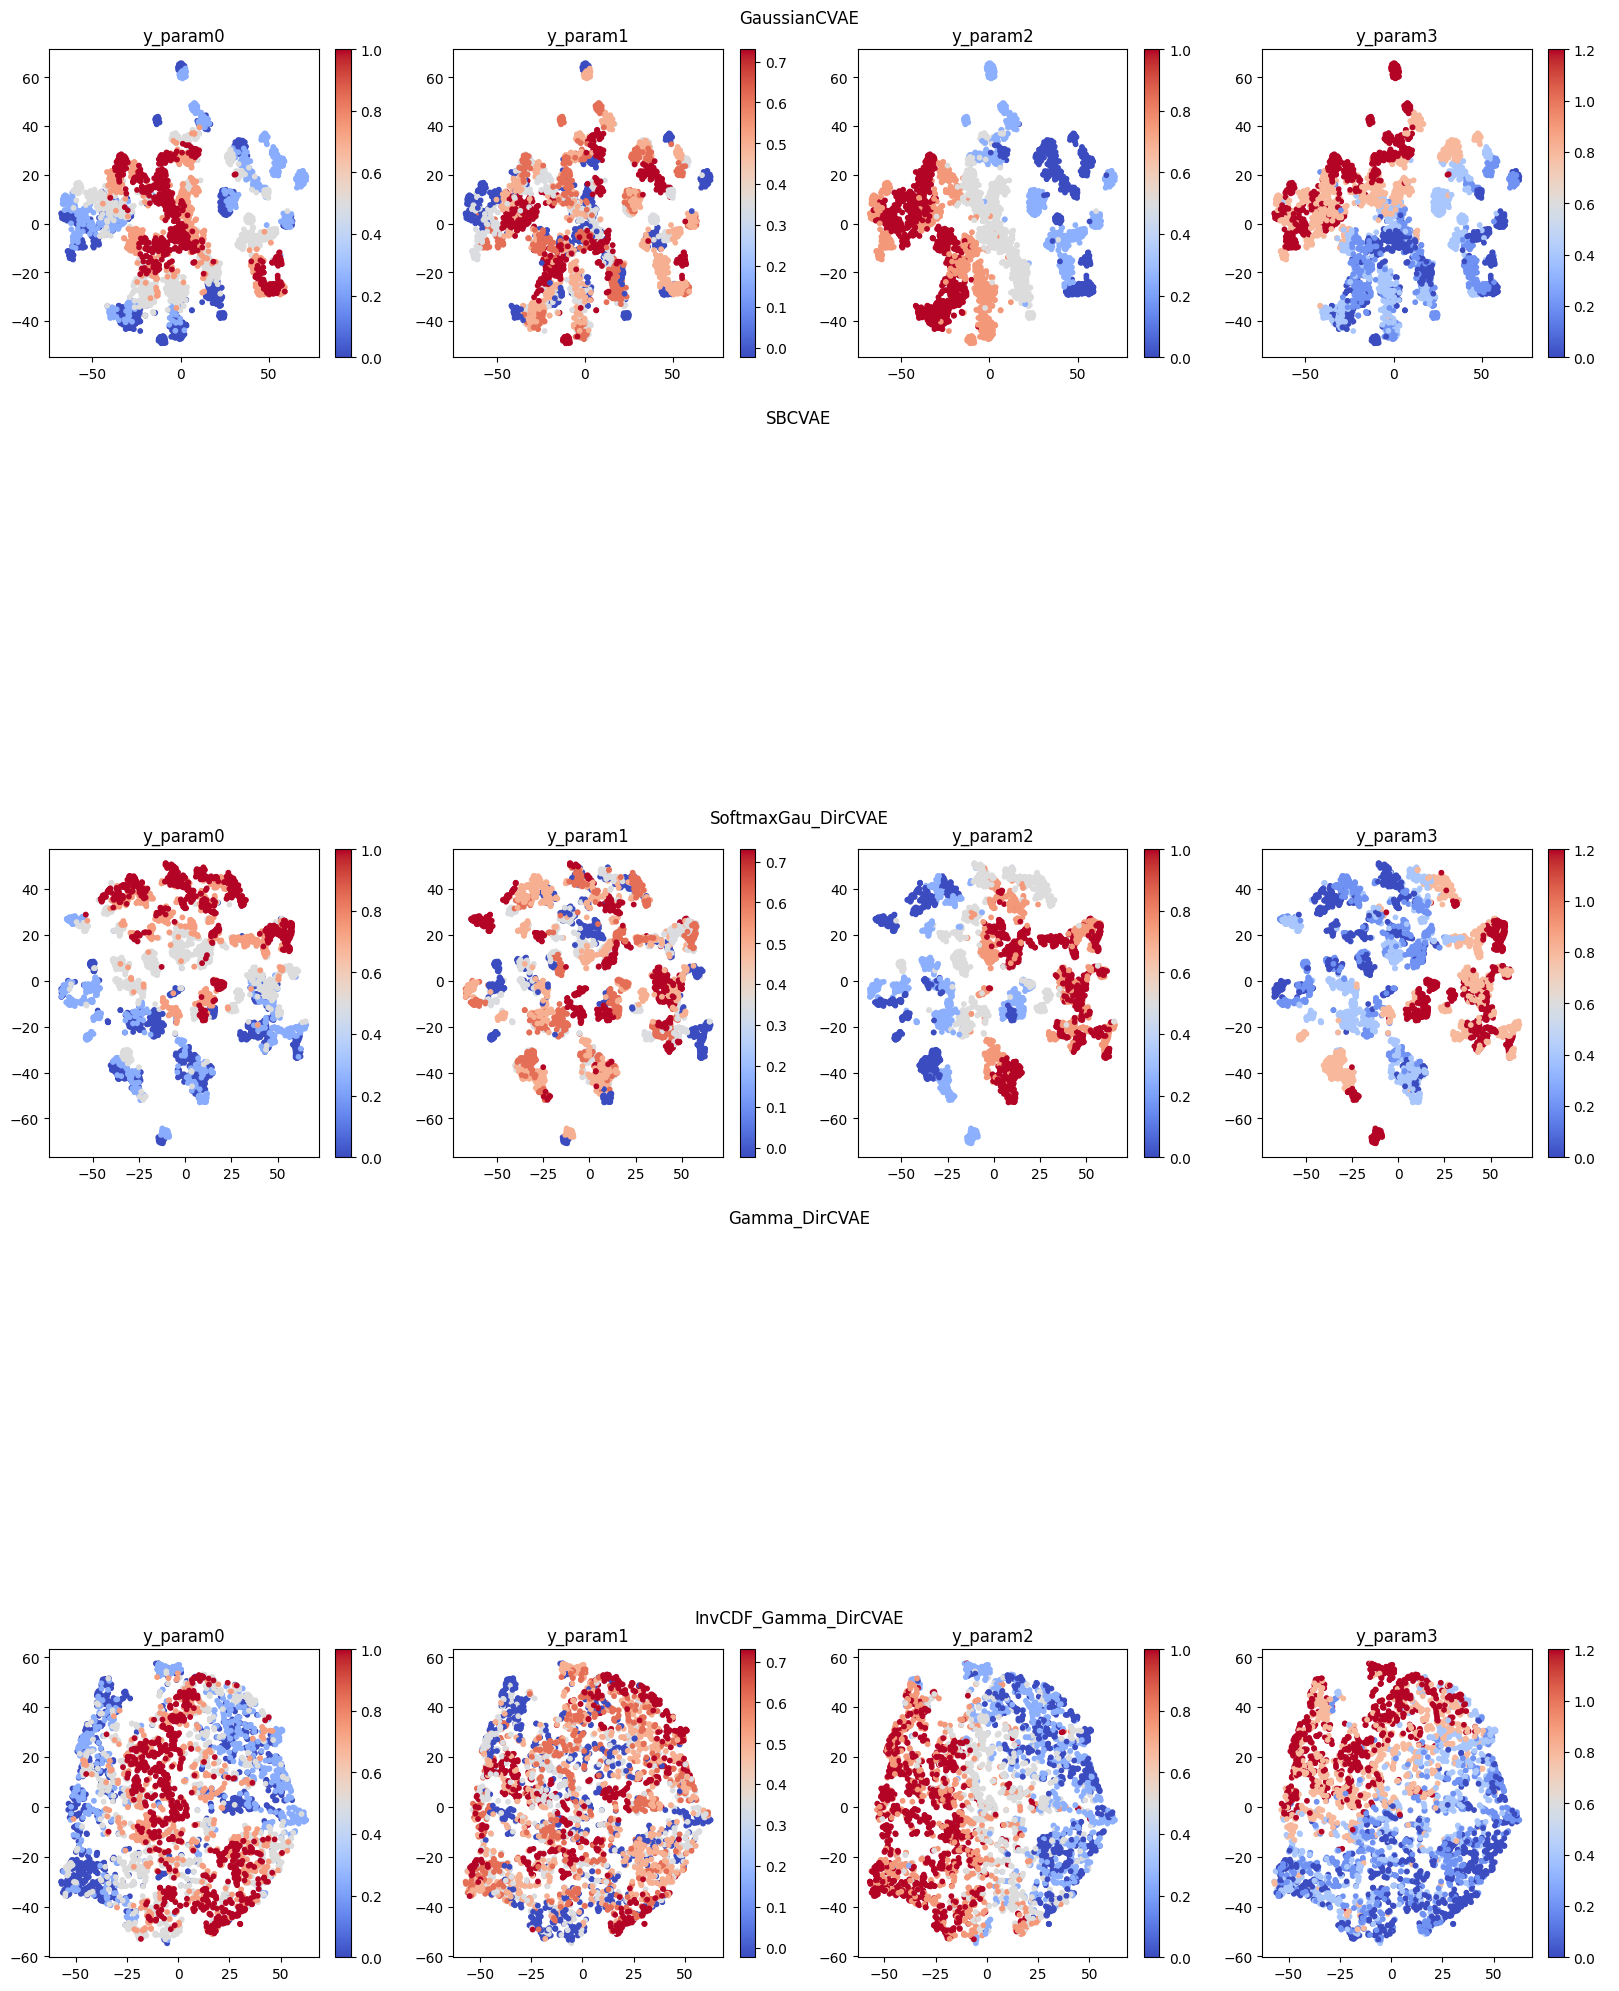

In [43]:
fig, axs = plt.subplots(nrows=len(latent_dic), ncols=1, figsize=(20, 4*len(latent_dic)))
plt.subplots_adjust(hspace=0.5)

# add subfigure per subplot
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = [fig.add_subfigure(gs) for gs in gridspec]

for i, (name, [prior_para1, prior_para2, prior_z, pos_para1, pos_para2, pos_z, weight]) in enumerate(latent_dic.items()):  
    subfigs[i].suptitle(f'{name}')
    
#     model_tsne = TSNE(n_components=2, random_state=0, method='exact')
    model_tsne = TSNE(n_components=2, random_state=0)
    try:
        z_embed = model_tsne.fit_transform(prior_z)

        # create 1x4 subplots per subfig
        axs = subfigs[i].subplots(nrows=1, ncols=4)

        for col, ax in enumerate(axs.ravel()):
            param = outputs[:,col]
            img = ax.scatter(z_embed[:, 0], z_embed[:, 1], c=param, cmap='coolwarm', s=10)
            fig.colorbar(img)
            ax.set_title('y_param' + str(col))
    except:
        pass
        
plt.show()